# Computing with Oscillators: A Speech Demo

* author: Nand Chandravadia

***

This demo notebook is based on:

- **Part 1: Speech Data**
- **Part 2: Oscillator Model**

In [1]:
%pip install -q --force-reinstall airavata-python-sdk[notebook]

import airavata_jupyter_magic


%authenticate

%request_runtime hpc_cpu --file=cybershuttle.yml --walltime=120 --use=NeuroData25VC1:cloud,expanse:shared,anvil:shared

%switch_runtime hpc_cpu


'\n%pip install -q --force-reinstall airavata-python-sdk[notebook]\n\nimport airavata_jupyter_magic\n\n\n%authenticate\n\n%request_runtime hpc_cpu --file=cybershuttle.yml --walltime=120 --use=NeuroData25VC1:cloud,expanse:shared,anvil:shared\n\n%switch_runtime hpc_cpu\n\n!git clone https://github.com/cyber-shuttle/NeuroDATA_2025 workspace\n%cd workspace\n'

In [ ]:
!git clone https://github.com/cyber-shuttle/NeuroDATA_2025 workspace
%cd workspace

## Part 1: Speech Data

Speech is typically recorded on a microphone, such as the one on your cell-phone or laptop. Standard audio recorders usually record at sampling rates of 48 kHz. Here, we will look at two speech datasets of English and Arabic Speech. 

In [2]:
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, Image, display
from torch.distributions.uniform import Uniform
import yaml

device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on Device: {}".format(device))


plt.style.use('seaborn-v0_8')


Running on Device: cpu


### Load Speech Data

All the speech data is found in `/data'

In [3]:
audio_path = "./data/English_7.wav"
#audio_path = "./data/English_0.wav"
#audio_path = "./data/Arabic_5.wav"
#audio_path = "./data/Arabic_9.wav"




In [4]:
#Specify language dataset 

language = "English" #{"English, Arabic"}

In [5]:
#load speech data params 
def load_speech_data_parameters(language):

    with open("data.yaml", "r") as f:
        config = yaml.safe_load(f)

    # Choose which model config to use
    data_config = config["data"][language]

    
    # specific hyperparameters    
    data_params = {
        "original_sampling_rate": data_config["original_sampling_rate"],
        "batch_length": data_config["batch_length"],
        "downsample_length": data_config["downsample_length"],
        "final_sample_length": data_config["final_sample_length"],
    }

    return data_params

In [6]:
data_params = load_speech_data_parameters(language)

In [7]:
print(data_params)

{'original_sampling_rate': 44100, 'batch_length': 70119, 'downsample_length': 8000, 'final_sample_length': 12720}


In [8]:
def load_speech(path, data_params):

    #load raw data
    audio, sample_rate = torchaudio.load(path)

    target_length = data_params["batch_length"] #48000
    current_length = audio.shape[1]

    padding = torch.zeros((audio.shape[0], target_length - current_length))
    audio = torch.cat((audio, padding), dim=1)
    

    #downsample to 8kHz
    original_sampling_rate = data_params["original_sampling_rate"]
    new_sampling_rate = data_params["downsample_length"]
    
    transform = torchaudio.transforms.Resample(orig_freq=original_sampling_rate, 
                                            new_freq=new_sampling_rate)

    #appy new sampling rate
    signal = transform(audio)
    
    #apply a normalization [-1, 1]
    max_value = signal[0,:].abs().max()
    new_signal=signal[0,:]*(1/max_value)
    

    return new_signal, new_sampling_rate


In [9]:
new_signal, new_sampling_rate = load_speech(audio_path, data_params)

In [10]:
Audio(data=new_signal, rate=new_sampling_rate)

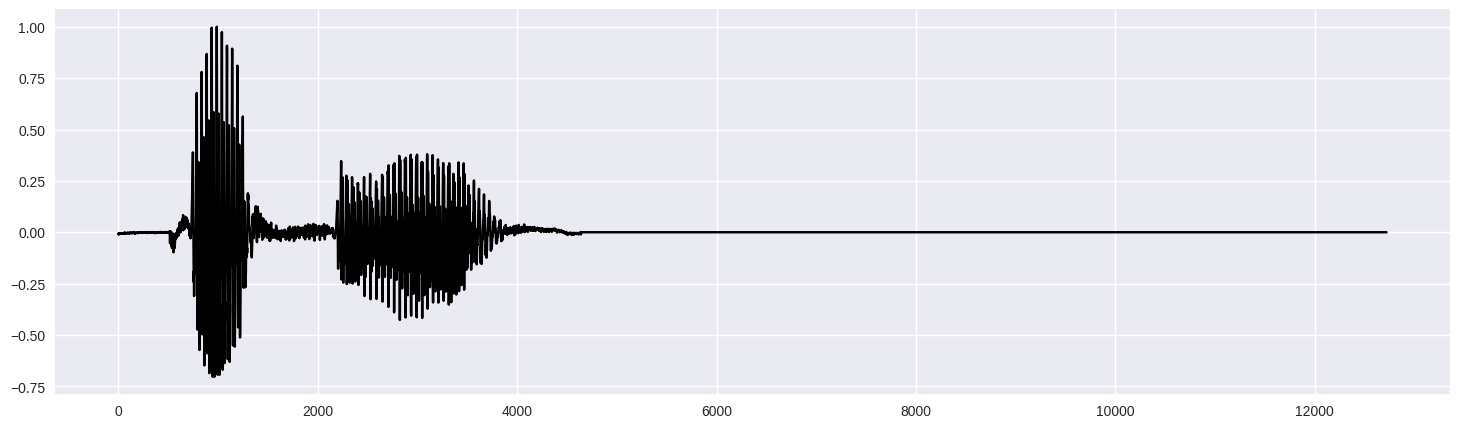

In [11]:
time = np.linspace(start = 0, stop = len(new_signal), num = len(new_signal))

fig, axes = plt.subplots(1,1, figsize = (18, 5))

axes.plot(time, new_signal, color = 'black')


axes.grid(True)

# Part 2: Model: Network of Coupled Oscillators

Now, let's look at the form and structure of the model. 

<div style="text-align: center;">
  <img src="assets/network_oscillators.png" alt="Oscillatory Network" width="500" height="500"/>
</div>

In [12]:
from model import coRNN

In [13]:
#User Specify Model
model_number = 1 #{1,2}

######################################
model_id = language + "_" + str(model_number)
network_path_trained = "./models/" + language + "_" + str(model_number) + "_" + "trained" + ".pth"
network_path_untrained = "./models/" + language + "_" + str(model_number) + "_" + "untrained" + ".pth"

In [14]:
def load_hyperparameters(model_id, device):
    # Load the hyperparams file
    with open("hyperparams.yaml", "r") as f:
        config = yaml.safe_load(f)

    # Choose which model config to use
    model_config = config["models"][model_id]

    # Set the seed
    generator = torch.Generator(device=device)
    generator.manual_seed(model_config["random_seed"])

    # Define frequency range
    low_frequency, high_frequency = 0.1, 20
    gamma_tensor = (high_frequency - low_frequency) * torch.rand((1, model_config["n_hid"]), generator=generator, device=device) + low_frequency

    # Define damping range
    low_damping, high_damping = 0.1, 80
    epsilon_tensor = (high_damping - low_damping) * torch.rand((1, model_config["n_hid"]), generator=generator, device=device) + low_damping

    
    # specific hyperparameters    
    params = {
        "network_type": model_config["network_type"],
        "n_inp": model_config["n_inp"],
        "n_hid": model_config["n_hid"],
        "n_out": model_config["n_out"],
        "dt": model_config["dt"],
        "learning_rate": model_config["learning_rate"],
        "random_seed": model_config["random_seed"]
    }

    return params, gamma_tensor, epsilon_tensor
    

In [15]:
params, gamma_tensor, epsilon_tensor = load_hyperparameters(model_id, device)

In [16]:
print(params)

{'network_type': 'coRNN', 'n_inp': 1, 'n_hid': 256, 'n_out': 10, 'dt': 0.005, 'learning_rate': 0.0042, 'random_seed': 46158}


In [17]:
print(gamma_tensor)

tensor([[19.6913, 19.4489, 12.2054, 12.2918, 12.6657, 19.8576,  4.7588, 12.8646,
         12.0392,  3.0227, 18.1119, 15.3649,  0.4127,  5.3992, 10.0377, 14.8552,
          0.5481, 19.0296, 15.9213,  6.4606,  7.1186, 13.8129, 15.3700, 10.6561,
          4.8701,  5.6495,  5.3886,  8.5827,  3.4890, 14.2998,  8.0778,  3.7189,
          0.1177,  5.7860, 13.2939, 17.7840,  1.6044, 15.0733, 18.7596, 15.6241,
         19.0673,  1.4045, 19.6524,  5.6149, 11.9666,  7.8535,  0.9294, 13.3159,
         18.1583, 14.4740, 18.0139, 17.1257, 13.0036, 18.8395, 13.6307,  9.5452,
         11.5178, 16.4946,  9.8210, 11.7729,  3.9409, 12.9688,  8.5622, 17.8336,
         13.9302, 13.3320,  6.1827, 12.7034,  7.9974, 13.0499, 13.4332,  7.8404,
         14.0979,  8.7032, 10.0454, 18.2976, 10.9170, 10.3303, 19.5585, 11.3139,
         15.1643, 18.6777,  8.9487,  5.4521,  3.1941, 13.8307,  2.0216,  1.7756,
         13.8432,  5.3469,  2.1203, 18.3651,  2.1267, 11.5450, 18.3868, 13.3338,
          6.0910, 11.0324, 1

In [18]:
print(epsilon_tensor)

tensor([[25.7836, 66.5816, 71.0418, 42.4872, 64.3109, 34.1962, 59.9409, 39.6675,
         16.9790, 76.7601, 71.8906, 29.1543,  2.1733,  0.2372, 51.1738, 45.4451,
         12.2693, 15.9128, 39.5999, 62.1265,  7.7512,  9.7358, 74.0856, 79.8997,
         36.9302, 77.6096, 43.2643, 60.0994, 64.9725, 51.9213, 47.1925, 49.4069,
         13.3925,  6.1129, 44.9360, 58.1919, 32.4331, 64.4204, 18.2432, 47.3963,
         55.8283, 50.4200, 11.8097, 36.4390, 17.1106, 52.8116, 50.4120, 59.2507,
         21.2921, 18.2133, 41.5825, 54.6594, 61.9146, 45.1347, 52.0302, 68.2331,
         59.1756, 24.0910,  2.9974,  6.0320, 63.7991, 74.3412, 51.3588, 59.6317,
         63.9538, 14.7572, 25.7016, 21.8700, 28.9376, 26.3223, 35.9854, 43.9212,
         17.1428, 77.7071, 16.2930, 73.1816, 30.3436, 20.5653, 47.9496, 69.8648,
         12.5067, 61.8672, 32.0397, 64.5930, 19.8543,  2.5756, 44.9594, 71.3255,
         46.3242, 66.5570, 52.0559, 70.2494, 50.4688, 11.0563, 65.1432, 44.2543,
         65.8418, 42.1274,  

In [19]:
#load the untrained and trained model

def load_model(network_path, params, gamma_tensor, epsilon_tensor, device):

    #params
    network_type = params["network_type"]
    n_inp = params["n_inp"]
    n_hid = params["n_hid"]
    n_out = params["n_out"]
    dt = params["dt"]

    #load model
    model = coRNN(network_type = network_type, n_inp = n_inp, n_hid = n_hid,
                                  n_out = n_out, dt = dt, 
                                  gamma = gamma_tensor, epsilon = epsilon_tensor)

    # Load the saved state dictionary into the model
    model.load_state_dict(torch.load(network_path, map_location=device))

    # Set the model to evaluation mode
    model.eval()
    
    return model

In [20]:
untrained_model = load_model(network_path=network_path_untrained, params=params, gamma_tensor=gamma_tensor, epsilon_tensor=epsilon_tensor, device=device)
trained_model = load_model(network_path=network_path_trained, params=params, gamma_tensor=gamma_tensor, epsilon_tensor=epsilon_tensor, device=device)

untrained_model_weights = untrained_model.state_dict()
trained_model_weights = trained_model.state_dict()

In [21]:
#LOAD MODEL WEIGHTS

def load_model_weights(model):

    #load model weights!
    recurrent_weights = model["cell.R.weight"]
    recurrent_velocity_weights = model["cell.F.weight"]

    return recurrent_weights, recurrent_velocity_weights

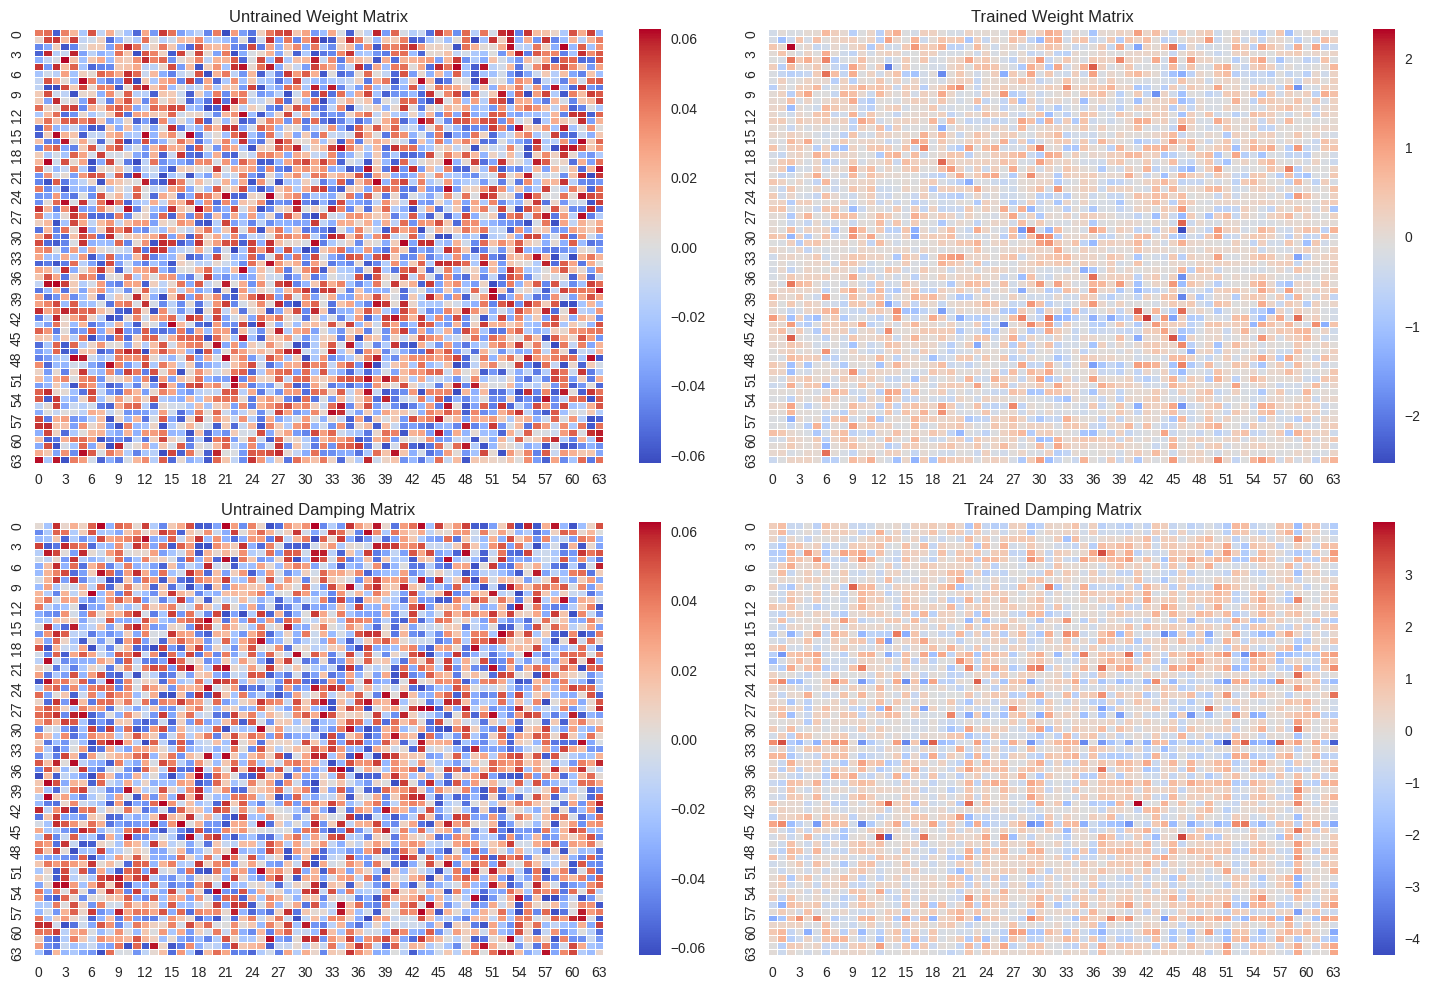

In [22]:
# Visualize Model WEIGHTS
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

untrained_weights, untrained_damping = load_model_weights(untrained_model_weights)
trained_weights, trained_damping = load_model_weights(trained_model_weights)

index_start, index_end = 0, 64
# Plot the first heatmap on the left subplot
sns.heatmap(untrained_weights[index_start:index_end, index_start:index_end], ax=axes[0,0], cmap='coolwarm', linewidth=0.5)
axes[0,0].set_title('Untrained Weight Matrix')

sns.heatmap(untrained_damping[index_start:index_end, index_start:index_end], ax=axes[1,0], cmap='coolwarm', linewidth=0.5)
axes[1,0].set_title('Untrained Damping Matrix')


# Plot the second heatmap on the right subplot
sns.heatmap(trained_weights[index_start:index_end, index_start:index_end], ax=axes[0,1],cmap='coolwarm', linewidth=0.5)
axes[0,1].set_title('Trained Weight Matrix')

sns.heatmap(trained_damping[index_start:index_end, index_start:index_end], ax=axes[1,1],cmap='coolwarm', linewidth=0.5)
axes[1,1].set_title('Trained Damping Matrix')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [23]:
#Feed the Model Speech!

#format input
new_signal = new_signal.reshape(1, 1, data_params["final_sample_length"])  #8000
new_signal = new_signal.permute(2, 0, 1)
input_signal = new_signal


save_output_trained, save_hy_trained, save_hz_trained, save_activation_trained = trained_model(input_signal)
save_output_untrained, save_hy_untrained, save_hz_untrained, save_activation_untrained = untrained_model(input_signal)

In [24]:
#What does the model think?

def plot_response(signal, output, title_name, axes):

    SAMPLING_FREQUENCY = data_params["final_sample_length"]
    TIME=1
    
    input = signal[:,0,0]
    output = output[:, 0, :]
    softmax = torch.nn.Softmax(dim=1)
    output = softmax(output)


    color_map = {
    0: "navy",
    1: "darkgreen",
    2: "maroon",
    3: "purple",
    4: "teal",
    5: "olive",
    6: "sienna",
    7: "royalblue",
    8: "darkorange",
    9: "indigo"}

 

    time = torch.arange(start=0, end=TIME, step=1/SAMPLING_FREQUENCY)

    for target in range(0,10):
        axes.plot(time, output.detach()[:, target], label = target, color = color_map[target], alpha = 0.7, linewidth=3)


    #set axes
    title = "Model Prediction" + "," + title_name
    axes.set_title(title, fontsize=24)
    
    axes.set_xlabel("Time (in seconds)", fontsize=18)
    axes.set_ylabel("Probability", fontsize=18)
    axes.set_ylim(-0.05,1.05)
    axes.tick_params(axis='both', labelsize=18)  # Set tick label size 
    axes.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
    axes.grid(True)


    return


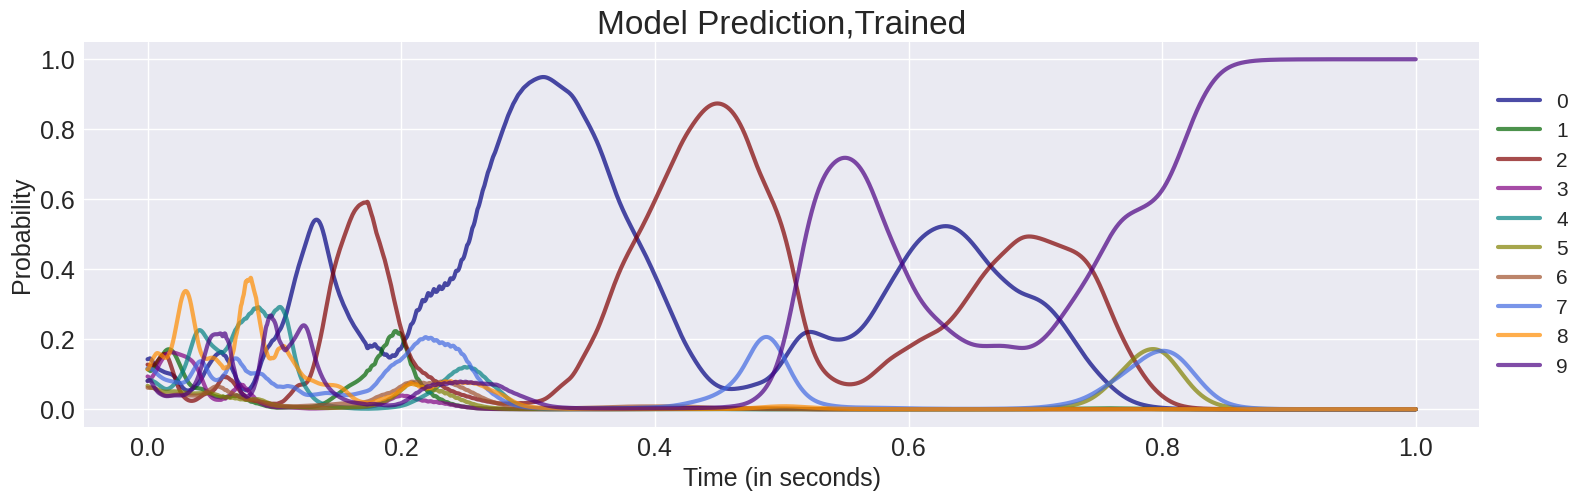

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(18,5))

plot_response(signal=input_signal, 
            output=save_output_trained, 
            title_name="Trained",
            axes = axes)

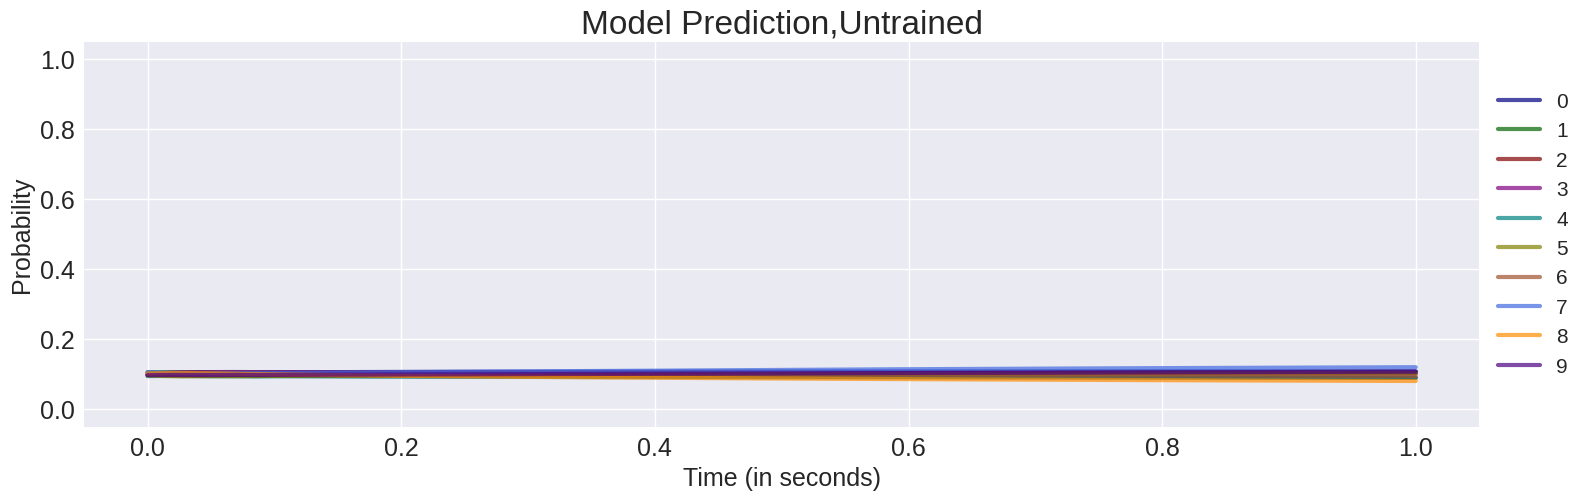

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(18,5))

plot_response(signal=input_signal, 
            output=save_output_untrained, 
            title_name="Untrained",
            axes = axes)